## purpose
1. load in the timecourse of each ROI
2. calculate the mean activity for each ROI for each given event
3. use the multivariate pattern of each network (each ROI contributes one value) to determine whether the network carries information about the event during encoding and retrieval

## load in libraries

In [37]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from sklearn import preprocessing
import seaborn as sns 
from brainiak.isfc import isc
from brainiak.fcma.util import compute_correlation
import brainiak.funcalign.srm
from brainiak import image, io
import pandas as pd
import matplotlib.pyplot as plt
from pandas import *
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nipype.interfaces import afni
from nipy.labs.mask import intersect_masks
from scipy.stats import zscore, norm
from sklearn import linear_model
from isc_reorder import isc_reorder
from isc_recall import isc_recall
import pickle

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

import multiprocessing as mp
import time

import matplotlib
%autosave 5
%matplotlib inline

Autosaving every 5 seconds


In [2]:
data_dir = '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/fmriprep_v20.1.1/fmriprep/'
analysis_dir = '/Users/alexbarnett/Documents/TTTvsPMAT/fMRI/SRM_2020/'

In [3]:
#set variables
subj_list = pd.read_excel(analysis_dir+'subjlist.xlsx')
movie_list = ['barmaid','bluestreets']
subj_recall=pd.read_excel(analysis_dir+'subj_recall_sessions_run.xlsx')
event_boundaries = pd.read_excel(analysis_dir+'fmri_recall_event_boundaries_all.xlsx')
roi_list = pd.read_excel(analysis_dir+'roilist.xlsx')

n_sub = 24

#sub_motion_outliers_recall=np.load(analysis_dir+'sub_motion_outliers_recall.npy')
#subj_recall['motion_percent'] = sub_motion_outliers_recall

In [4]:
## set net labels
net_label = ['VIS','SOM-MOT','SAL1','DAN1','SAL2','DAN2','LANG','FPN','AUD','ATN','MTN','PMN','MPN','antHC','postHC']

glasser_nodes=pd.read_excel(analysis_dir+'within_subj_fc/hc_glasser_nodes.xlsx')

In [5]:
# Run linear regression to deconvolve
def deconv(V, design):
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(design, V.T)
    return regr.coef_

In [6]:
# load in subject designs

with open(analysis_dir+'subject_design_label_bluestreets.data', 'rb') as filehandle:
        # read the data as binary data stream
        subject_design_label_bluestreets = pickle.load(filehandle)
with open(analysis_dir+'subject_design_label_barmaid.data', 'rb') as filehandle:
        # read the data as binary data stream
        subject_design_label_barmaid = pickle.load(filehandle)

## calculate mean ROI activity

### only run once, then load up the saved next time

In [3184]:
# load in the data preprocessed for RSA
# have to go through each roi, append that ROI to an array for each subject, and then append that array to the sample array
n_rois = 362
n_TRs = 840
##barmaid
k=0
# cycle through subject
barmaid_movie_isc_data = np.zeros([n_sub, n_rois, n_TRs])
for sub in range(n_sub):
    sub_isc_data = []
    # go through all the glasser rois (hippocampal rois will be done after)
    for roi in range(len(glasser_nodes)-4):
        epi = np.load(analysis_dir+'glasser_ROIs/epi_'+roi_list.iloc[roi]['Unnamed: 2']+'_'+subj_list['subj_id'][sub]+ movie_list[k]+'_viewing.npy')
        sub_isc_data.append(np.mean(epi,1))
    sub_isc_data = np.array(sub_isc_data)
    barmaid_movie_isc_data[sub,:358,:np.shape(sub_isc_data)[1]] = sub_isc_data

##bluestreets
k=1
# cycle through subject
bluestreets_movie_isc_data = np.zeros([n_sub, n_rois, n_TRs])
for sub in range(n_sub):
    sub_isc_data = []
    # go through all the glasser rois (hippocampal rois will be done after)
    for roi in range(len(glasser_nodes)-4):
        epi = np.load(analysis_dir+'glasser_ROIs/epi_'+roi_list.iloc[roi]['Unnamed: 2']+'_'+subj_list['subj_id'][sub]+ movie_list[k]+'_viewing.npy')
        sub_isc_data.append(np.mean(epi,1))
    sub_isc_data = np.array(sub_isc_data)
    bluestreets_movie_isc_data[sub,:358,:np.shape(sub_isc_data)[1]] = sub_isc_data

In [3439]:
np.save('barmaid_movie_isc_data.npy',barmaid_movie_isc_data)

In [3440]:
np.save('bluestreets_movie_isc_data.npy',bluestreets_movie_isc_data)

In [9]:
barmaid_movie_isc_data = np.load('barmaid_movie_isc_data.npy')
bluestreets_movie_isc_data = np.load('bluestreets_movie_isc_data.npy')

## viewing spatial ISC

### barmaid

In [19]:
# initialize arrays
isc_barmaid_sub_event_z=[]
isc_iterations=5000
net_event_ISC_barmaid= []
net_event_ISC_bluestreets= []
isc_null_barmaid=[]
isc_null_bluestreets=[]



design_barmaid = np.load(analysis_dir+movie_list[0]+'_design.npy')
design_bluestreets = np.load(analysis_dir+movie_list[1]+'_design.npy')

# cycle through networks
for net in range(0,13):
    
    # get movie data and calculate average ROI activation patterns
    
    ## barmaid 
    n, TR, n_events = np.shape(design_barmaid)
    index = glasser_nodes['community_sublabels']==net+1
    network_data = barmaid_movie_isc_data[:,index,:]

    network_data = np.transpose(network_data,[2,1,0])

    # organize data in proper order
    movie_xform_data = []

    for sub in range(n_sub):
        movie_xform_data.append(network_data[:, :, sub])

    #normalize data
    # Iterate through the subjects
    for sub in range(n_sub):    
        movie_xform_data[sub] = stats.zscore(movie_xform_data[sub], axis=0, ddof=1)
        movie_xform_data[sub] = np.nan_to_num(movie_xform_data[sub])
    roi_num = np.shape(movie_xform_data)[2]

    #calculate event level voxel patterns
    beta_barmaid = np.zeros([roi_num,n_events,n_sub])
    for sub in range(n_sub):
        beta_pre = np.zeros([roi_num,n_events,n_sub])
        beta_pre = deconv(np.transpose(movie_xform_data,[2,1,0])[:, :,sub], design_barmaid[0][:np.shape(movie_xform_data)[1],:])
        beta_pre[abs(beta_pre)<0.00000000000001]=0 ## python has a problem with rounding things and thus some elements need to be put to 0
        beta_barmaid[:,:,sub] = zscore(beta_pre[:, :n_events],axis=0, ddof=1)
        
    ## bluestreets 
    n, TR, n_events = np.shape(design_bluestreets)
    network_data = bluestreets_movie_isc_data[:,index,:]

    network_data = np.transpose(network_data,[2,1,0])

    # organize data in proper order
    movie_xform_data = []

    for sub in range(n_sub):
        movie_xform_data.append(network_data[:, :, sub])

    #normalize data
    # Iterate through the subjects
    for sub in range(n_sub):    
        movie_xform_data[sub] = stats.zscore(movie_xform_data[sub], axis=0, ddof=1)
        movie_xform_data[sub] = np.nan_to_num(movie_xform_data[sub])
    roi_num = np.shape(movie_xform_data)[2]

    #calculate event level voxel patterns
    beta_bluestreets = np.zeros([roi_num,n_events,n_sub])
    for sub in range(n_sub):
        beta_pre = np.zeros([roi_num,n_events,n_sub])
        beta_pre = deconv(np.transpose(movie_xform_data,[2,1,0])[:, :,sub], design_bluestreets[0][:np.shape(movie_xform_data)[1],:])
        beta_pre[abs(beta_pre)<0.00000000000001]=0 ## python has a problem with rounding things and thus some elements need to be put to 0
        beta_bluestreets[:,:,sub] = zscore(beta_pre[:, :n_events],axis=0, ddof=1)

        
        
    # calculate event level isc for correct labels
    ## barmaid
    spatial_event_isc_reconstructed = isc(np.transpose(beta_barmaid,[1,0,2])[1:,:,:], collapse_subj=False)
    spatial_subject_isc = np.nanmean(spatial_event_isc_reconstructed,0)
    net_event_ISC_barmaid.append(spatial_subject_isc)
    
    ## bluestreets
    spatial_event_isc_reconstructed = isc(np.transpose(beta_bluestreets,[1,0,2])[1:,:,:], collapse_subj=False)
    spatial_subject_isc = np.nanmean(spatial_event_isc_reconstructed,0)
    net_event_ISC_bluestreets.append(spatial_subject_isc)

    
    # calculate event level isc for scrambled labels
    
    spatial_subject_isc_null_barmaid = []
    spatial_subject_isc_null_bluestreets = []
    for iteration in range(isc_iterations):
        #barmaid
        spatial_event_isc_reconstructed_null = isc_reorder(np.transpose(beta_barmaid,[1,0,2])[1:,:,:], collapse_subj=False)
        spatial_subject_isc_null_barmaid.append(np.nanmean(spatial_event_isc_reconstructed_null,0))
        
        #bluestreets
        spatial_event_isc_reconstructed_null = isc_reorder(np.transpose(beta_bluestreets,[1,0,2])[1:,:,:], collapse_subj=False)
        spatial_subject_isc_null_bluestreets.append(np.nanmean(spatial_event_isc_reconstructed_null,0))
        
        


    isc_null_barmaid.append(spatial_subject_isc_null_barmaid)
    isc_null_bluestreets.append(spatial_subject_isc_null_bluestreets)
    


## viewing ISC

### z-score from null

In [14]:
# ATN

In [15]:
# z-score for barmaid
(np.mean(net_event_ISC_barmaid[9]) - np.mean(np.nanmean(isc_null_barmaid[9],axis = 1)))/np.std(np.nanmean(isc_null_barmaid[9],axis = 1))

11.707831777355043

In [20]:
# Z-score for bluestreet
(np.mean(net_event_ISC_bluestreets[9]) - np.mean(np.nanmean(isc_null_bluestreets[9],axis = 1)))/np.std(np.nanmean(isc_null_bluestreets[9],axis = 1))

12.023761430859052

In [ ]:
# z-score combined
(np.mean([net_event_ISC_barmaid[9],net_event_ISC_bluestreets[9]]) - np.concatenate([np.mean(np.nanmean(isc_null_barmaid[9],axis = 1)),np.mean(np.nanmean(isc_null_barmaid[9],axis = 1))]))/np.std(np.nanmean(isc_null_barmaid[9],axis = 1))

In [21]:
#MTN

In [22]:
# z-score for barmaid
(np.mean(net_event_ISC_barmaid[10]) - np.mean(np.nanmean(isc_null_barmaid[10],axis = 1)))/np.std(np.nanmean(isc_null_barmaid[10],axis = 1))

16.093636572887497

In [23]:
# Z-score for bluestreet
(np.mean(net_event_ISC_bluestreets[10]) - np.mean(np.nanmean(isc_null_bluestreets[10],axis = 1)))/np.std(np.nanmean(isc_null_bluestreets[10],axis = 1))

17.58484731220832

In [24]:
# PMN

In [25]:
# z-score for barmaid
(np.mean(net_event_ISC_barmaid[11]) - np.mean(np.nanmean(isc_null_barmaid[11],axis = 1)))/np.std(np.nanmean(isc_null_barmaid[11],axis = 1))

13.85073271184999

In [26]:
# Z-score for bluestreet
(np.mean(net_event_ISC_bluestreets[11]) - np.mean(np.nanmean(isc_null_bluestreets[11],axis = 1)))/np.std(np.nanmean(isc_null_bluestreets[11],axis = 1))

13.864926076100726

In [27]:
# MPN

In [28]:
# z-score for barmaid
(np.mean(net_event_ISC_barmaid[12]) - np.mean(np.nanmean(isc_null_barmaid[12],axis = 1)))/np.std(np.nanmean(isc_null_barmaid[12],axis = 1))

4.870431214838614

In [29]:
# Z-score for bluestreet
(np.mean(net_event_ISC_bluestreets[12]) - np.mean(np.nanmean(isc_null_bluestreets[12],axis = 1)))/np.std(np.nanmean(isc_null_bluestreets[12],axis = 1))

5.79330070216496

## plot effects for hippocampal-cortical networks

In [30]:
nets_of_interest = [10,11,9,12]

In [31]:
net_order = [1,2,0,3]

In [32]:
colors = ['#34A853','#4285F4','#EA4335','#FBBC05'];

In [33]:
net_names_select = [ 'MTN', 'PMN','ATN', 'MPN']

In [34]:
isc_null_bluestreets_select= isc_null_bluestreets[9:13]

In [35]:
net_event_ISC_bluestreets_select=net_event_ISC_bluestreets[9:13]

In [40]:
isc_null_barmaid_select= isc_null_barmaid[9:13]

In [41]:
net_event_ISC_barmaid_select=net_event_ISC_barmaid[9:13]

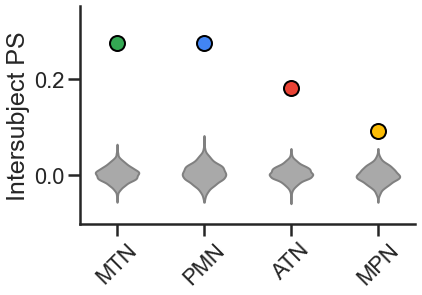

In [286]:
matplotlib.rcParams.update({'font.size': 20})

ax = plt.subplot()
for net in range(np.size(nets_of_interest)):
    violin_parts = plt.violinplot(np.concatenate([np.nanmean(isc_null_barmaid_select[net_order[net]],axis=1),
                                                  np.nanmean(isc_null_bluestreets_select[net_order[net]],axis=1)]),showextrema=False,positions=[net+1])    
    for pc in violin_parts['bodies']:
        pc.set_facecolor('darkgray')
        pc.set_edgecolor('gray')
        pc.set_alpha(1)
        # get the center
        #m = np.mean(pc.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        #pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
    plt.plot(net+1,np.mean([np.nanmean(net_event_ISC_barmaid_select[net_order[net]]),
                                       np.nanmean(net_event_ISC_bluestreets_select[net_order[net]])]),marker='o', markersize=15,markeredgewidth=2,markeredgecolor='black',linewidth=0,mfc = colors[net])
    #plt.errorbar(net+1, np.mean([np.nanmean(net_event_ISC_barmaid_select[net_order[net]]),np.nanmean(net_event_ISC_bluestreets_select[net_order[net]])]),
    #         yerr = stats.sem(np.concatenate([net_event_ISC_barmaid_select[net_order[net]],
    #                                          net_event_ISC_bluestreets_select[net_order[net]]])),
    #        capsize=5,color = 'black')
plt.xticks(range(1,np.size(nets_of_interest)+1),net_names_select,rotation=45)
plt.ylabel('Intersubject PS',fontsize=25)

plt.ylim([-0.1, .35])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## recall-recall ISC

In [53]:
# cycle through subject
recall_isc_data = np.zeros([np.shape(subj_recall)[0], n_rois, n_TRs])
for j, sub in subj_recall.iterrows():
    sub_isc_data = []
    # go through all the glasser rois (hippocampal rois will be done after)
    for roi in range(len(glasser_nodes)-4):
        epi = np.load(analysis_dir+'glasser_ROIs/epi_'+roi_list.iloc[roi]['Unnamed: 2']+'_'+sub['subj_id']+ sub['movie']+sub['run']+'_recall.npy')
        sub_isc_data.append(np.mean(epi,1))
    sub_isc_data = np.array(sub_isc_data)
    recall_isc_data[j,:358,:np.shape(sub_isc_data)[1]] = sub_isc_data


In [ ]:
np.save(analysis_dir+'recall_isc_data.npy',recall_isc_data)

In [54]:
recall_isc_data = np.load(analysis_dir+'recall_isc_data.npy')

In [110]:
isc_iterations = 5000

net_event_ISC_barmaid_recall= []
isc_null_barmaid_recall=[]
net_tracker_isc = []
subject_label_isc= []
isc_barmaid_sub_event_recall=[]

for net in range(13):
    # create a list of subjects to loop through
    subj_id = subj_recall['subj_id'].unique()

    num_run_barmaid = np.sum(subj_recall['movie']=='barmaid')

    # open the design matrices of the recall of subjects
    with open(analysis_dir+'barmaid_recall_design.data', 'rb') as filehandle:
    # read the data as binary data stream
        design = pickle.load(filehandle)
    n = design.shape[0]
    n_events = design[0].shape[1]
    
    index = glasser_nodes['community_sublabels']==net+1
    roi_num = np.sum(index)
    
    recall_beta_sample = np.zeros([roi_num,n_events,n_sub])
    row = 0
    for sub in range(len(subj_id)):
        temp_df = subj_recall[subj_recall['subj_id']==subj_id[sub]][subj_recall['movie']=='barmaid'].reset_index()
        num_runs = len(temp_df)

        beta_pre = []
        for run in range(num_runs):
            
            recall_data = recall_isc_data[run,index,:]

            recall_data = np.transpose(recall_data,[1,0])

            # organize data in proper order
            recall_xform=stats.zscore(recall_data, axis=0, ddof=1)
            recall_xform = np.nan_to_num(recall_xform)
            

            #calculate event level voxel patterns
            #beta_pre = np.zeros([roi_num,n_events,num_runs])

            for ppt in range(num_runs):
                beta_pre.append(deconv(np.transpose(recall_xform,[1,0])[:, :design[row].shape[0]], design[row]))
            row = row+1
        beta_pre = np.array(beta_pre)
        beta_pre[abs(beta_pre)<0.00000000000001]=0
        recall_beta_combined = np.nansum(np.array(beta_pre),0)
        recall_beta_combined = zscore(recall_beta_combined,axis=0,ddof = 1)
        recall_beta_sample[:,:,sub] = recall_beta_combined
        
        
    #calculate event level isc for correct and scrambled labels
    spatial_event_isc_reconstructed = isc_recall(np.transpose(recall_beta_sample,[1,0,2])[1:,:,:], collapse_subj=False)
    spatial_subject_isc = np.nanmean(spatial_event_isc_reconstructed,0)

    spatial_subject_isc_null = []
    for iteration in range(isc_iterations):
        spatial_event_isc_reconstructed_null = isc_reorder(np.transpose(recall_beta_sample,[1,0,2])[1:,:,:], collapse_subj=False)
        spatial_subject_isc_null.append(np.nanmean(spatial_event_isc_reconstructed_null,0))

    net_event_ISC_barmaid_recall.append(spatial_subject_isc)
    isc_null_barmaid_recall.append(spatial_subject_isc_null)
    


## bluestreets recall-recall

In [111]:
isc_iterations = 5000

net_event_ISC_bluestreets_recall= []
isc_null_bluestreets_recall=[]
isc_bluestreets_sub_event_recall=[]

for net in range(13):
    # create a list of subjects to loop through
    subj_id = subj_recall['subj_id'].unique()

    num_run = np.sum(subj_recall['movie']=='bluestreets')

    # open the design matrices of the recall of subjects
    with open(analysis_dir+'bluestreets_recall_design.data', 'rb') as filehandle:
    # read the data as binary data stream
        design = pickle.load(filehandle)
    n = design.shape[0]
    n_events = design[0].shape[1]
    
    index = glasser_nodes['community_sublabels']==net+1
    roi_num = np.sum(index)
    
    recall_beta_sample = np.zeros([roi_num,n_events,n_sub])
    row = 0
    for sub in range(len(subj_id)):
        temp_df = subj_recall[subj_recall['subj_id']==subj_id[sub]][subj_recall['movie']=='bluestreets'].reset_index()
        num_runs = len(temp_df)

        beta_pre = []
        for run in range(num_runs):
            
            recall_data = recall_isc_data[row+num_run_barmaid,index,:]

            recall_data = np.transpose(recall_data,[1,0])

            # organize data in proper order
            recall_xform=stats.zscore(recall_data, axis=0, ddof=1)
            recall_xform = np.nan_to_num(recall_xform)
            

            #calculate event level voxel patterns
            #beta_pre = np.zeros([roi_num,n_events,num_runs])

            for ppt in range(num_runs):
                beta_pre.append(deconv(np.transpose(recall_xform,[1,0])[:, :design[row].shape[0]], design[row]))
             ## python has a problem with rounding things and thus some elements need to be put to 0
            #beta=zscore(beta_pre[:, :],axis=0, ddof=1)
            #np.save(analysis_dir+'/betas/recall_beta_nosrm_glasser'+str(roi_list[i])+movie_list[k]+'_smooth.npy',beta)
            row = row+1
        beta_pre = np.array(beta_pre)
        beta_pre[abs(beta_pre)<0.00000000000001]=0
        recall_beta_combined = np.nansum(np.array(beta_pre),0)
        recall_beta_combined = zscore(recall_beta_combined,axis=0,ddof = 1)
        #plt.figure()
        #plt.imshow(recall_beta_combined,aspect='auto')
        #plt.title(subj_list[sub])
        recall_beta_sample[:,:,sub] = recall_beta_combined
        
        
    #calculate event level isc for correct and scrambled labels
    spatial_event_isc_reconstructed = isc_recall(np.transpose(recall_beta_sample,[1,0,2])[1:,:,:], collapse_subj=False)
    spatial_subject_isc = np.nanmean(spatial_event_isc_reconstructed,0)

    spatial_subject_isc_null = []
    for iteration in range(isc_iterations):
        spatial_event_isc_reconstructed_null = isc_reorder(np.transpose(recall_beta_sample,[1,0,2])[1:,:,:], collapse_subj=False)
        spatial_subject_isc_null.append(np.nanmean(spatial_event_isc_reconstructed_null,0))

    net_event_ISC_bluestreets_recall.append(spatial_subject_isc)
    isc_null_bluestreets_recall.append(spatial_subject_isc_null)
    
    # get the ISC for each subject and event in a row
    #for sub in range(n_sub):
    #    for event in range(n_events):
    #        isc_bluestreets_sub_event_recall.append(spatial_event_isc_reconstructed[event,sub])
            #net_tracker_isc.append(net+1)
            #subject_label_isc.append(subj_list['subj_id'][sub])




### calculate z -scores for recall-recall

In [112]:
## ATN

In [113]:
#barmaid
(np.nanmean(net_event_ISC_barmaid_recall[9],axis=0) - np.mean(np.nanmean(isc_null_barmaid_recall[9],axis=1)))/np.std(np.nanmean(isc_null_barmaid_recall[9],axis=1))

1.9138227538100556

In [114]:
#bluestreets
(np.nanmean(net_event_ISC_bluestreets_recall[9],axis=0) - np.mean(np.nanmean(isc_null_bluestreets_recall[9],axis=1)))/np.std(np.nanmean(isc_null_bluestreets_recall[9],axis=1))

4.69877469810118

In [115]:
## MTN

In [116]:
#barmaid
(np.nanmean(net_event_ISC_barmaid_recall[10],axis=0) - np.mean(np.nanmean(isc_null_barmaid_recall[10],axis=1)))/np.std(np.nanmean(isc_null_barmaid_recall[10],axis=1))

3.4188728291607777

In [117]:
#bluestreets
(np.nanmean(net_event_ISC_bluestreets_recall[10],axis=0) - np.mean(np.nanmean(isc_null_bluestreets_recall[10],axis=1)))/np.std(np.nanmean(isc_null_bluestreets_recall[10],axis=1))

4.495672592533873

In [118]:
## PMN

In [119]:
#barmaid
(np.nanmean(net_event_ISC_barmaid_recall[11],axis=0) - np.mean(np.nanmean(isc_null_barmaid_recall[11],axis=1)))/np.std(np.nanmean(isc_null_barmaid_recall[11],axis=1))

2.984272437991761

In [120]:
#bluestreets
(np.nanmean(net_event_ISC_bluestreets_recall[11],axis=0) - np.mean(np.nanmean(isc_null_bluestreets_recall[11],axis=1)))/np.std(np.nanmean(isc_null_bluestreets_recall[11],axis=1))

7.284822918591033

In [121]:
## MPN

In [122]:
#barmaid
(np.nanmean(net_event_ISC_barmaid_recall[12],axis=0) - np.mean(np.nanmean(isc_null_barmaid_recall[12],axis=1)))/np.std(np.nanmean(isc_null_barmaid_recall[12],axis=1))

2.045274320887095

In [123]:
#bluestreets
(np.nanmean(net_event_ISC_bluestreets_recall[12],axis=0) - np.mean(np.nanmean(isc_null_bluestreets_recall[12],axis=1)))/np.std(np.nanmean(isc_null_bluestreets_recall[12],axis=1))

0.7893116559634198

## plot effects of recall-recall

In [124]:
net_event_ISC_barmaid_recall_select = net_event_ISC_barmaid_recall[9:13]
isc_null_barmaid_recall_select = isc_null_barmaid_recall[9:13]

In [125]:
net_event_ISC_bluestreets_recall_select = net_event_ISC_bluestreets_recall[9:13]
isc_null_bluestreets_recall_select = isc_null_bluestreets_recall[9:13]

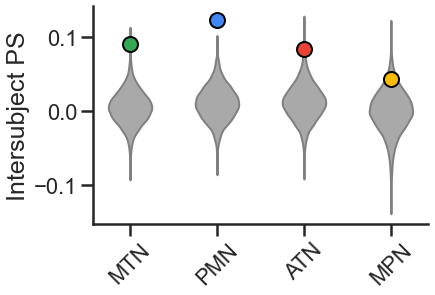

In [288]:
matplotlib.rcParams.update({'font.size': 20})

ax = plt.subplot()
for net in range(np.size(nets_of_interest)):
    violin_parts = plt.violinplot(np.concatenate([np.nanmean(isc_null_barmaid_recall_select[net_order[net]],axis=1),
                                                  np.nanmean(isc_null_bluestreets_recall_select[net_order[net]],axis=1)]),showextrema=False,positions=[net+1])    
    for pc in violin_parts['bodies']:
        pc.set_facecolor('darkgray')
        pc.set_edgecolor('gray')
        pc.set_alpha(1)
        # get the center
        #m = np.mean(pc.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        #pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        
    plt.plot(net+1,np.mean([np.nanmean(net_event_ISC_barmaid_recall_select[net_order[net]]),
                                       np.nanmean(net_event_ISC_bluestreets_recall_select[net_order[net]])]),marker='o', markersize=15,markeredgewidth=2,
             markeredgecolor='black',linewidth=0,mfc = colors[net])
    #plt.errorbar(net+1, np.mean([np.nanmean(net_event_ISC_barmaid_recall_select[net_order[net]]),
    #                             np.nanmean(net_event_ISC_bluestreets_recall_select[net_order[net]])]),
    #         yerr = stats.sem(np.concatenate([net_event_ISC_barmaid_recall_select[net_order[net]],
    #                                          net_event_ISC_bluestreets_recall_select[net_order[net]]])),
    #         capsize=5,color = 'black')
plt.xticks(range(1,np.size(nets_of_interest)+1),net_names_select,rotation=45)
plt.ylabel('Intersubject PS',fontsize=25)

#plt.ylim([-0.1, .35])

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)